# Imports

In [1]:
from math import sqrt, log, pow, erf, e
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt

# Black-Scholes Model Initialization

In [29]:
def standard_normal_cdf(x):
    return 0.5 * (1 + erf(x / sqrt(2)))

def d1(S, K, t, r, vol):
    numerator = log(S/K) + (r + pow(vol, 2)/2) * t
    denominator = vol * sqrt(t)
    return numerator / denominator

def d2(S, K, t, r, vol):
    return d1(S, K, t, r, vol) - vol * sqrt(t)

def call_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(d2(S, K, t, r, vol))
    return Nd1 * S - Nd2 * K * pow(e, -1 * r * t)

def put_price(S, K, t, r, vol):
    Nd1 = standard_normal_cdf(- 1 * d1(S, K, t, r, vol))
    Nd2 = standard_normal_cdf(- 1 * d2(S, K, t, r, vol))
    return Nd2 * K * pow(e, -1 * r * t) - S * Nd1


# YFinance API 

In [30]:
ticker = 'AAPL'
option = yf.Ticker(ticker)
option.options

('2024-05-17',
 '2024-05-24',
 '2024-05-31',
 '2024-06-07',
 '2024-06-14',
 '2024-06-21',
 '2024-06-28',
 '2024-07-19',
 '2024-08-16',
 '2024-09-20',
 '2024-10-18',
 '2024-11-15',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16',
 '2026-06-18',
 '2026-12-18')

# Fetching Call and Put Chains

In [31]:
# Picking a date from the above 
date = '2024-06-28'

def fetch_options_data(ticker_symbol, date):
    ticker = yf.Ticker(ticker_symbol)
    options_data = ticker.option_chain(date)
    return options_data.calls, options_data.puts



calls, puts = fetch_options_data(ticker, date)
calls = pd.DataFrame(calls)
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240628C00165000,2024-05-13 19:35:50+00:00,165.0,23.65,22.05,24.05,4.799999,25.464188,8.0,2,0.398932,True,REGULAR,USD
1,AAPL240628C00170000,2024-05-13 19:43:03+00:00,170.0,18.97,18.05,18.95,3.719999,24.393438,3.0,31,0.330634,True,REGULAR,USD
2,AAPL240628C00175000,2024-05-13 15:35:51+00:00,175.0,13.60,13.40,14.05,2.600000,23.636366,4.0,4,0.271370,True,REGULAR,USD
3,AAPL240628C00180000,2024-05-13 19:54:58+00:00,180.0,10.11,9.05,10.05,2.620000,34.979973,104.0,59,0.245247,True,REGULAR,USD
4,AAPL240628C00185000,2024-05-13 19:57:34+00:00,185.0,6.40,6.25,6.60,1.810000,39.433550,378.0,166,0.223457,True,REGULAR,USD


# Calculating Parameters

In [32]:
# Stock Price
def get_current_stock_price(ticker_symbol):
    stock = yf.Ticker(ticker_symbol)
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    return current_price


# Interest Rate
def get_10yr_treasury_rate():
    # 10 year treasury ticker
    treasury_ticker = "^TNX"

    now = datetime.now()
    ten_years_ago = now.replace(year=now.year - 10)

    treasury_data = yf.download(treasury_ticker, start=ten_years_ago, end=now)
    last_yield = treasury_data['Close'].iloc[-1]
    return last_yield


# Date
def get_date(date_str):
    # 'YYYY-MM-DD'
    date_object = datetime.strptime(date_str, '%Y-%m-%d')

    current_date = datetime.now()
    years_difference = (date_object - current_date).days / 365.25
    return years_difference


# Volatility
def calculate_volatility(ticker):

    today = datetime.now()
    one_year_ago = today.replace(year=today.year-1)
    data = yf.download(ticker, start=one_year_ago, end=today)

    # Calculate daily returns
    data['Daily_Return'] = data['Adj Close'].pct_change()

    # std of daily returns
    daily_volatility = data['Daily_Return'].std()
    annualized_volatility = daily_volatility * np.sqrt(252)

    return annualized_volatility



S = get_current_stock_price(ticker)
r = get_10yr_treasury_rate()
t = get_date(date)
vol = calculate_volatility(ticker)

r = r / 100

print(f"Riskfree rate: {r}")
print(f"Years difference: {t}")
print(f"The current stock price of {ticker} is: {S}")
print(f"Stock price of {ticker}: {S}")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Riskfree rate: 0.044809999465942385
Years difference: 0.12320328542094455
The current stock price of AAPL is: 186.27999877929688
Stock price of AAPL: 186.27999877929688


# DF with the Black-Scholes Values

In [33]:
main_df = calls.copy()
columns_to_drop = ['lastTradeDate', 'lastPrice', 'volume', 'openInterest', 'contractSize', 'currency']
main_df.drop(columns=columns_to_drop, inplace=True)
main_df['bsmValuation'] = main_df.apply(lambda row: call_price(S, row['strike'], t, r, vol), axis=1) # Call
#main_df['bsmValuation'] = main_df.apply(lambda row: put_price(S, row['strike'], t, r, vol), axis=1) # Put
main_df.head(10)

,contractSymbol,strike,bid,ask,change,percentChange,impliedVolatility,inTheMoney,bsmValuation
0,AAPL240628C00165000,165.0,22.05,24.05,4.799999,25.464188,0.398932,True,22.373660
1,AAPL240628C00170000,170.0,18.05,18.95,3.719999,24.393438,0.330634,True,17.717409
2,AAPL240628C00175000,175.0,13.40,14.05,2.600000,23.636366,0.271370,True,13.403192
3,AAPL240628C00180000,180.0,9.05,10.05,2.620000,34.979973,0.245247,True,9.608357
4,AAPL240628C00185000,185.0,6.25,6.60,1.810000,39.433550,0.223457,True,6.481737
5,AAPL240628C00190000,190.0,3.50,4.00,1.300000,50.980392,0.210457,False,4.092713
6,AAPL240628C00195000,195.0,1.05,2.35,0.750000,56.390965,0.208016,False,2.410287
7,AAPL240628C00200000,200.0,1.01,1.22,0.580000,90.625010,0.202645,False,1.321488
8,AAPL240628C00205000,205.0,0.53,0.64,0.340000,130.769260,0.203987,False,0.674252
9,AAPL240628C00210000,210.0,0.27,0.35,0.110000,55.000000,0.209481,False,0.320382


# Greeks Implementation

In [34]:
# Call Options
def delta_call(S, K, t, r, vol):
    return norm.cdf(d1(S, K, t, r, vol))

def gamma_call(S, K, t, r, vol):
    numerator = norm.pdf(d1(S, K, t, r, vol))
    denominator = S * vol * sqrt(e)
    return numerator / denominator

def vega_call(S, K, t, r, vol):
    return S * norm.pdf(d1(S, K, t, r, vol)) * sqrt(t)

def theta_call(S, K, t, r, vol):
    numerator = S * norm.pdf(d1(S, K, t, r, vol)) * vol
    denominator = 2 * sqrt(t)
    return -1 * (numerator / denominator) - r * K * pow(e, -1 * r * t) * norm.cdf(d2(S, K, t, r, vol))

def rho_call(S, K, t, r, vol):
    return K * t * pow(e, -1 * r * t * norm.cdf(d2(S, K, t, r, vol)))


# Put Options
def delta_put(S, K, t, r, vol):
    return norm.cdf(d1(S, K, t, r, vol)) - 1

def gamma_put(S, K, t, r, vol):
    numerator = norm.pdf(d1(S, K, t, r, vol))
    denominator = S * vol * sqrt(e)
    return numerator / denominator

def vega_put(S, K, t, r, vol):
    return S * norm.pdf(d1(S, K, t, r, vol)) * sqrt(t)

def theta_put(S, K, t, r, vol):
    numerator = S * norm.pdf(d1(S, K, t, r, vol)) * vol
    denominator = 2 * sqrt(t)
    return -1 * (numerator / denominator) + r * K * pow(e, -1 * r * t) * norm.cdf(-1 * d2(S, K, t, r, vol))

def rho_put(S, K, t, r, vol):
    return -1 * K * t * pow(e, -1 * r * t * norm.cdf(-1 * d2(S, K, t, r, vol)))

In [35]:
greeks_df = main_df.copy()

# Calls
greeks_df['delta'] = greeks_df.apply(lambda row: delta_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['gamma'] = greeks_df.apply(lambda row: gamma_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['vega'] = greeks_df.apply(lambda row: vega_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['theta'] = greeks_df.apply(lambda row: theta_call(S, row['strike'], t, r, vol), axis=1)
greeks_df['rho'] = greeks_df.apply(lambda row: rho_call(S, row['strike'], t, r, vol), axis=1)

# Puts
'''greeks_df['delta'] = greeks_df.apply(lambda row: delta_put(S, row['strike'], t, r, vol), axis=1)
greeks_df['gamma'] = greeks_df.apply(lambda row: gamma_put(S, row['strike'], t, r, vol), axis=1)
greeks_df['vega'] = greeks_df.apply(lambda row: vega_put(S, row['strike'], t, r, vol), axis=1)
greeks_df['theta'] = greeks_df.apply(lambda row: theta_put(S, row['strike'], t, r, vol), axis=1)
greeks_df['rho'] = greeks_df.apply(lambda row: rho_put(S, row['strike'], t, r, vol), axis=1)'''

greeks_df.head(10)

,contractSymbol,strike,bid,ask,change,percentChange,impliedVolatility,inTheMoney,bsmValuation,delta,gamma,vega,theta,rho
0,AAPL240628C00165000,165.0,22.05,24.05,4.799999,25.464188,0.398932,True,22.373660,0.965502,0.001227,4.992670,-11.163030,20.221120
1,AAPL240628C00170000,170.0,18.05,18.95,3.719999,24.393438,0.330634,True,17.717409,0.919062,0.002410,9.806544,-14.943315,20.839847
2,AAPL240628C00175000,175.0,13.40,14.05,2.600000,23.636366,0.271370,True,13.403192,0.839228,0.003921,15.959039,-19.530518,21.463042
3,AAPL240628C00180000,180.0,9.05,10.05,2.620000,34.979973,0.245247,True,9.608357,0.724169,0.005369,21.849506,-23.584907,22.091066
4,AAPL240628C00185000,185.0,6.25,6.60,1.810000,39.433550,0.223457,True,6.481737,0.583207,0.006270,25.515355,-25.563442,22.722845
5,AAPL240628C00190000,190.0,3.50,4.00,1.300000,50.980392,0.210457,False,4.092713,0.434555,0.006323,25.733020,-24.608689,23.356118
6,AAPL240628C00195000,195.0,1.05,2.35,0.750000,56.390965,0.208016,False,2.410287,0.298075,0.005570,22.667505,-21.023544,23.988341
7,AAPL240628C00200000,200.0,1.01,1.22,0.580000,90.625010,0.202645,False,1.321488,0.187848,0.004329,17.619113,-16.000068,24.617639
8,AAPL240628C00205000,205.0,0.53,0.64,0.340000,130.769260,0.203987,False,0.674252,0.108793,0.002997,12.197600,-10.910120,25.243278
9,AAPL240628C00210000,210.0,0.27,0.35,0.110000,55.000000,0.209481,False,0.320382,0.058007,0.001864,7.585086,-6.708378,25.865520


# Pricing European Options With Self Set Parameters

In [2]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the Black-Scholes price of an European option.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate (annual)
    sigma : float
        Volatility of the underlying asset
    option_type : str
        Type of option, 'call' or 'put'

    Returns:
    float
        Price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    elif option_type == 'put':
        option_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    return option_price



S = 100  # Spot price
K = 100  # Strike price
T = 1    # Time to maturity
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
steps = 100 # Time steps
simulations = 10000  # Number of simulation paths

# Calculate European call/put 
call_price = black_scholes(S, K, T, r, sigma, 'call')
put_price = black_scholes(S, K, T, r, sigma, 'put')

print(f"European Call Price (Black-Scholes): {call_price:.2f}")
print(f"European Put Price (Black-Scholes): {put_price:.2f}")

European Call Price (Black-Scholes): 10.45
European Put Price (Black-Scholes): 5.57


# Monte Carlo Simulation to Price American Options

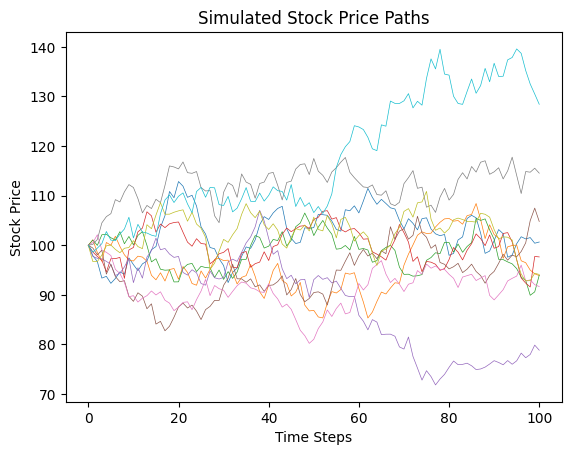

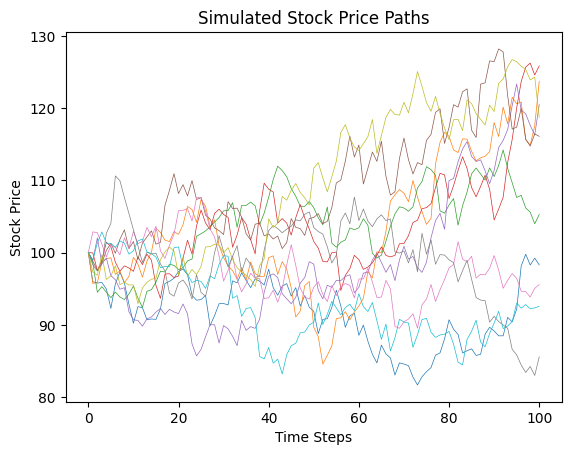

American Call Option Price (Monte Carlo): 18.13
American Put Option Price (Monte Carlo): 11.57


In [3]:
def american_option_monte_carlo(S, K, T, r, sigma, steps, simulations, option_type='put'):
    """
    Monte Carlo simulation for American options with plotting.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate
    sigma : float
        Volatility
    steps : int
        Number of steps in the simulation
    simulations : int
        Number of simulation paths
    option_type : str
        Type of the option ('call' or 'put')
    """
    dt = T / steps
    discount_factor = np.exp(-r * dt)
    option_values = np.zeros(simulations)
    paths = np.zeros((simulations, steps + 1))

    for i in range(simulations):
        paths[i, 0] = S
        for j in range(1, steps + 1):
            z = np.random.standard_normal()
            paths[i, j] = paths[i, j - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

        if option_type == 'put':
            payoffs = np.maximum(K - paths[i], 0)
        elif option_type == 'call':
            payoffs = np.maximum(paths[i] - K, 0)
        else:
            raise ValueError("Option type must be 'call' or 'put'")

        option_value = payoffs[-1]
        for j in range(steps - 1, 0, -1):
            option_value = discount_factor * option_value
            option_value = max(option_value, payoffs[j])
        option_values[i] = option_value


    plt.figure(facecolor='white')
    for i in range(min(10, simulations)):
        plt.plot(paths[i], lw=0.5)
    plt.title('Simulated Stock Price Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.show()

    # Average the maximum payoff across all simulations
    return np.mean(option_values)



S = 100  # Spot price
K = 100  # Strike price
T = 1    # Time to maturity
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
steps = 100 # Time steps
simulations = 10000  # Number of simulation paths


# Calculate American call/put 
american_call_price = american_option_monte_carlo(S, K, T, r, sigma, steps, simulations, 'call')
american_put_price = american_option_monte_carlo(S, K, T, r, sigma, steps, simulations, 'put')

print(f"American Call Option Price (Monte Carlo): {american_call_price:.2f}")
print(f"American Put Option Price (Monte Carlo): {american_put_price:.2f}")

# Binomial Tree Method to Price American Options

In [4]:
def binomial_tree_american_option(S, K, T, r, sigma, steps, option_type='call'):
    """
    Calculate the price of an American option using the binomial tree method.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate (annual)
    sigma : float
        Volatility of the underlying asset
    steps : int
        Number of steps in the binomial tree
    option_type : str
        Type of option, 'call' or 'put'

    Returns:
    float
        Price of the option
    """
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)

    # Initialize asset prices at maturity
    asset_prices = np.zeros(steps + 1)
    asset_prices[0] = S * (d ** steps)
    for i in range(1, steps + 1):
        asset_prices[i] = asset_prices[i - 1] * (u / d)

    # Initialize option values at maturity
    option_values = np.zeros(steps + 1)
    if option_type == 'call':
        option_values = np.maximum(0, asset_prices - K)
    elif option_type == 'put':
        option_values = np.maximum(0, K - asset_prices)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

    # Step back through the tree
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            option_values[i] = (p * option_values[i + 1] + (1 - p) * option_values[i]) * discount
            asset_prices[i] = asset_prices[i] / d
            if option_type == 'call':
                option_values[i] = np.maximum(option_values[i], asset_prices[i] - K)
            elif option_type == 'put':
                option_values[i] = np.maximum(option_values[i], K - asset_prices[i])

    return option_values[0]




S = 100  # Spot price
K = 100  # Strike price
T = 1    # Time to maturity
r = 0.05 # Risk-free rate
sigma = 0.2 # Volatility
steps = 100 # Time steps


# Calculate American call/put 
american_call_price = binomial_tree_american_option(S, K, T, r, sigma, steps, 'call')
american_put_price = binomial_tree_american_option(S, K, T, r, sigma, steps, 'put')

print(f"American Call Option Price (Binomial Tree): {american_call_price:.2f}")
print(f"American Put Option Price (Binomial Tree): {american_put_price:.2f}")

American Call Option Price (Binomial Tree): 10.43
American Put Option Price (Binomial Tree): 6.08
